In [1]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Other
import datetime
import os
from tqdm import tqdm
from pathlib import Path
from os import listdir
from fastaniso import anisodiff
from time import time


# Graphics
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim


# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd, convert_to_grayscale, get_dataset_name
from csv_dataloader import get_train_test_big_data, get_train_test_small_data
from math import floor

d:\Projects\PythonProjects\_venvs\3.9_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "FC_imgs_with_noise"

p_filtered_images = p_main_data / "FC_filtered_images"

p_gray_images = p_main_data / "gray_images"

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"{dataset_name = }\n{device = }")
device

device(type='cuda')

In [4]:
# Dataset
win_size = 7
step = 5
create_dataset = 0
if create_dataset:
    generate_csv(win_size=win_size, dump_to_file=5000, step=step, force_create_dataset=1)

In [5]:
win_size = 7
step = 5

dataset_name = get_dataset_name(win_size, step, p_scv_folder) #r"W5_S1_L3696640.csv"
dataset_name

'W7_S5_L146410.csv'

In [6]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/MyDrive/NIR/data/FC_data/W5_S5_L146410.zip


In [7]:

class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        # self.hid_n = 40
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.in_len),
            nn.BatchNorm1d(self.in_len),
            nn.ReLU(),
            nn.Linear(self.in_len, self.in_len * 2),
            nn.Dropout(0.5),
            nn.BatchNorm1d(self.in_len * 2),
            nn.ReLU(),
            nn.Linear(self.in_len * 2, self.in_len * 3),
            nn.Dropout(0.5),
            nn.BatchNorm1d(self.in_len * 3),
            nn.ReLU(),
            nn.Linear(self.in_len * 3, self.in_len * 3),
            nn.Dropout(0.5),
            nn.BatchNorm1d(self.in_len * 3),
            nn.ReLU(),
            nn.Linear(self.in_len * 3, self.in_len),
            nn.Dropout(0.5),
            nn.BatchNorm1d(self.in_len),
            nn.ReLU(),
            nn.Linear(self.in_len, self.out_len),
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

In [8]:
# losses = []
# losses_append = losses.append

# valid_losses = []
# valid_losses_append = valid_losses.append

# for epoch in range(num_epoches):
#     model.train()
#     train_loader, test_loader = get_train_test_data(scv_folder=p_scv_folder, dataset_name=dataset_name, batch_size=batch_size, train_size=0.8)
#     for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
#         # Data on cuda
#         data = data.to(device=device)
#         targets = targets.to(device=device)
        
#         # Forward
#         scores = model(data) # Equal to model.forward(data)
#         loss = criterion(scores, targets)

#         # Backprop
#         loss.backward()

#         # Gradient descent or adam step
#         optimizer.step()
#         optimizer.zero_grad()
        
#         if batch_ind % 3 == 0:
#             losses_append(loss.item())
#     scheduler.step()
#     model.eval()
#     with torch.no_grad():
#         for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
#             data = data.to(device=device)
#             targets = targets.to(device=device)
            
#             # Forward
#             scores = model(data) # Equal to model.forward(data)
#             loss = criterion(scores, targets)
#             valid_losses_append(loss.item())

In [9]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epoches = num_epoches
        self.p_scv_folder = p_scv_folder
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.train_losses = []
        self.valid_losses = []
        self.device = device

# loop = tqdm(enumerate(self.val_loader, start=1),
#                     leave=True,
#                     total=len(self.val_loader))

#                 loop.set_description(f"Valid epoch: {current_epoch}")
#                 loop.set_postfix(loss=round(loss.item(), 2))


    def _train(self, current_epoch):
        self.model.train()
        total_loss = 0
        for batch_index, (data, targets) in tqdm(enumerate(self.train_loader, start=1)):
            data = data.to(device=self.device)
            targets = targets.to(device=self.device)
            scores = self.model(data)
            loss = self.criterion(scores, targets)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            total_loss += loss.item()
        self.train_losses.append(total_loss / batch_index)
        
    def _valid(self, current_epoch):
        total_loss = 0
        self.model.eval()
        with torch.no_grad():
            for batch_index, (data, targets) in tqdm(enumerate(self.test_loader, start=1)):
                data = data.to(device=self.device)
                targets = targets.to(device=self.device)
                
                # Forward
                scores = self.model(data) # Equal to model.forward(data)
                loss = self.criterion(scores, targets)
                total_loss += loss.item()
        self.valid_losses.append(total_loss / batch_index)
    
    def fit(self):
        for epoch in range(self.num_epoches):
            self.train_loader, self.test_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.dataset_name,
                                                                      batch_size=self.batch_size, train_size=0.8)
            self._train(epoch)
            self._valid(epoch)
            if self.scheduler is not None:
                self.scheduler.step()
                
    def plot_graph(self):
        sns.set()
        fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle('Loss')

        ax_train.set_title("Train loss")
        ax_test.set_title("Valid loss")

        ax_train.set_ylabel('Loss value')
        ax_test.set_ylabel('Loss value')

        ax_train.set_xlabel("Batch")
        ax_test.set_xlabel("Batch")

        sns.lineplot(data=self.train_losses, ax=ax_train)
        sns.lineplot(data=self.valid_losses, ax=ax_test)

        plt.show()


In [10]:
# Hyperparameters 
learning_rate = 0.3
num_epoches = 6
batch_size = 64

model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
fit_model = FitModel(model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches)
fit_model.fit()

1831it [00:14, 129.30it/s]
458it [00:00, 595.92it/s]
1831it [00:12, 148.93it/s]
458it [00:00, 574.98it/s]
1831it [00:12, 148.08it/s]
458it [00:00, 572.83it/s]
1831it [00:12, 143.60it/s]
458it [00:00, 586.76it/s]
1831it [00:12, 146.69it/s]
458it [00:00, 580.18it/s]
1831it [00:12, 145.26it/s]
458it [00:00, 554.85it/s]


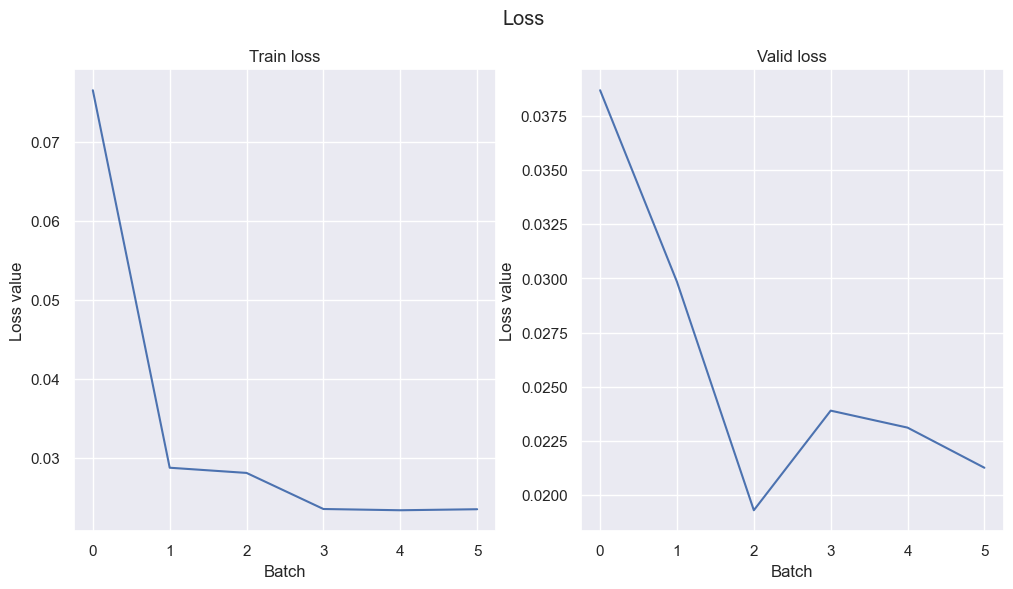

In [12]:
fit_model.plot_graph()

In [13]:
def check_without_filtering():
    images_names = listdir(p_noised_imgs)
    for name in images_names:
        check_ssim(p_noised_imgs, p_img, name)
    print()
    for name in images_names:
        check_gmsd(p_noised_imgs, p_img, name)
        
def check_after_filtering():
    images_names = listdir(p_noised_imgs)
    for name in images_names:
        check_ssim(p_filtered_images, p_img, name)
    print()
    for name in images_names:
        check_gmsd(p_filtered_images, p_img, name)
        


In [14]:
check_after_filtering()

1.jpg, SSIM = 0.884
10.jpg, SSIM = 0.889
2.jpg, SSIM = 0.897
3.jpg, SSIM = 0.875
4.jpg, SSIM = 0.897
5.jpg, SSIM = 0.856
6.jpg, SSIM = 0.888
7.jpg, SSIM = 0.936
8.jpg, SSIM = 0.901
9.jpg, SSIM = 0.869

1.jpg, GMSD = 0.045
10.jpg, GMSD = 0.068
2.jpg, GMSD = 0.040
3.jpg, GMSD = 0.065
4.jpg, GMSD = 0.053
5.jpg, GMSD = 0.062
6.jpg, GMSD = 0.039
7.jpg, GMSD = 0.052
8.jpg, GMSD = 0.043
9.jpg, GMSD = 0.075


In [15]:
check_without_filtering()

1.jpg, SSIM = 0.608
10.jpg, SSIM = 0.205
2.jpg, SSIM = 0.652
3.jpg, SSIM = 0.459
4.jpg, SSIM = 0.505
5.jpg, SSIM = 0.453
6.jpg, SSIM = 0.567
7.jpg, SSIM = 0.785
8.jpg, SSIM = 0.487
9.jpg, SSIM = 0.240

1.jpg, GMSD = 0.105
10.jpg, GMSD = 0.201
2.jpg, GMSD = 0.105
3.jpg, GMSD = 0.142
4.jpg, GMSD = 0.134
5.jpg, GMSD = 0.149
6.jpg, GMSD = 0.103
7.jpg, GMSD = 0.075
8.jpg, GMSD = 0.129
9.jpg, GMSD = 0.197


In [16]:
# p_img = p_raw_image / list_images[2]
# img_arr = np.array(ImageOps.grayscale(Image.open(p_img)))
# niters = [1, 2, 5, 10, 20]
# kappa = [1, 5, 10, 50, 100]
# for i in niters:
#     for k in kappa:
#         img_filtered = anisodiff(img_arr, niter=i, kappa=k)
#         img_filtered = img_filtered.astype(np.uint8)
#         Image.fromarray(img_filtered).save(f"{p_img}_I{i}_K{k}.jpg")

In [17]:
counter = 0

for i in range(0, 101):
    if i % 2 == 0:
        if i % 3 == 0:
            counter += 1

counter

17